In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os, cv2, random


import matplotlib.pyplot as plt

In [2]:
DATA_HOME_DIR = '/datasets/fast.ai/dogscats'

#Set path to sample/ path if desired
# path = DATA_HOME_DIR + '/' #'/sample/'
test_dir = DATA_HOME_DIR + '/test1/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_dir=DATA_HOME_DIR + '/train/'
valid_dir=DATA_HOME_DIR + '/valid/'


# ROWS = 150
# COLS = 150
# CHANNELS = 3

# train_images = [i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
# train_dogs =   [i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
# train_cats =   [i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# test_images =  [i for i in os.listdir(TEST_DIR)]

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

In [ ]:




model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
model.save('cats_and_dogs_small_3.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
# Fine Tune all layers

f_model = models.Sequential()
f_model.add(conv_base)
f_model.add(layers.Flatten())
f_model.add(layers.Dense(256, activation='relu'))
f_model.add(layers.Dense(1, activation='sigmoid'))


In [8]:
f_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
from keras.models import load_model

f_model=load_model('cats_and_dogs_small_4.h5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [11]:
# define early stopping callback
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]



f_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

# history = f_model.fit_generator(
#       train_generator,
#       steps_per_epoch=100,
#       epochs=100,
#       callbacks=callbacks_list,
#       validation_data=validation_generator,
#       validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_4.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# predict test classes
test_dir = DATA_HOME_DIR + '/test1/' 

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=50,class_mode=None)

# filenames = test_generator.filenames
# nb_samples = len(filenames)

# nb_samples
# predictions=f_model.predict(test_generator,nb_samples)

Found 0 images belonging to 0 classes.


In [14]:
test_dir

'/datasets/fast.ai/dogscats/test1/'

In [15]:

test_images =  [i for i in os.listdir(test_dir)]

ROWS = 150
COLS = 150
CHANNELS = 3

In [16]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img



def read_image(file_path,dir):
    img = cv2.imread(os.path.join(dir,file_path), cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images,dir):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS,CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        x = load_img(os.path.join(dir,test_images[i]), target_size=(150,150))
        x = img_to_array(x)
        x = np.expand_dims(x, axis=0)
#         image = read_image(image_file,dir)
        data[i] = x
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [17]:
test = prep_data(test_images,test_dir)

Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Processed 4750 of 12500
Processed 5000 of 12500
Processed 5250 of 12500
Processed 5500 of 12500
Processed 5750 of 12500
Processed 6000 of 12500
Processed 6250 of 12500
Processed 6500 of 12500
Processed 6750 of 12500
Processed 7000 of 12500
Processed 7250 of 12500
Processed 7500 of 12500
Processed 7750 of 12500
Processed 8000 of 12500
Processed 8250 of 12500
Processed 8500 of 12500
Processed 8750 of 12500
Processed 9000 of 12500
Processed 9250 of 12500
Processed 9500 of 12500
Processed 9750 of 12500
Processed 10000 of 12500
Processed 10250 of 12

In [18]:
print("Test shape: {}".format(test.shape))


Test shape: (12500, 150, 150, 3)


In [20]:
preds_class=f_model.predict(test)

In [30]:
# get the ids
ids = np.array([int(f[:f.find('.')]) for f in test_images])
ids

array([10592,  7217,  3653, ...,  2086, 11842,   736])

In [28]:
preds=preds_class[:,0]
preds[2]
isdog = preds.clip(min=0.05, max=0.95)

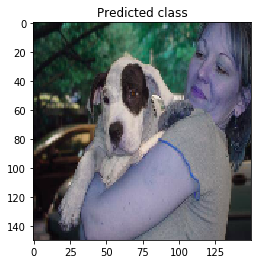

In [26]:
input_img=read_image(test_images[2],test_dir)
plt.title('Predicted class')
plt.imshow(input_img)

In [31]:
# Here we join the two columns into an array of [imageId, isDog]
subm = np.stack([ids,preds], axis=1)
subm[:5]

array([[1.0592e+04, 1.0000e+00],
       [7.2170e+03, 0.0000e+00],
       [3.6530e+03, 1.0000e+00],
       [4.3820e+03, 1.0000e+00],
       [2.9240e+03, 1.0000e+00]])

In [32]:
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')